# TODO
* Group values
* Sort rivers by distance
* Find attached rivers by distance

In [2]:
import requests
import pandas as pd
import folium
import sqlite3
import io
import matplotlib.pyplot as plt  #for data visualization operations
import seaborn as sns

# to show all rows and columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
def dict_factory(cursor, row):
    fields = [column[0] for column in cursor.description]
    return {key: value for key, value in zip(fields, row)}

# DB Connect

In [4]:
con = sqlite3.connect("pegelstaende.db")
con.row_factory = dict_factory
cur = con.cursor()
con.execute('PRAGMA foreign_keys = ON;')

In [5]:
# # Execute the DELETE statement
# cur.execute("PRAGMA foreign_keys = OFF")
# cur.execute("DELETE FROM timeseries WHERE value = 'XXX,XXX'")
# cur.execute("PRAGMA foreign_keys = ON")
# # Commit the changes
# con.commit()

In [6]:
def run(sql):
    r = cur.execute(sql)
    return(r.fetchall())

## Stations will no timeseries

In [7]:
stations = (pd.DataFrame(run("""SELECT 
        r.name As fluss,
        s.name AS station,
        max(ts.date) as last_date

    FROM rivers r
    LEFT JOIN stations s ON r.id = s.river_id
    LEFT JOIN timeseries ts ON s.uuid = ts.uuid
    GROUP BY s.uuid
    HAVING last_date is null
    ORDER BY fluss, station
    """)))
display(stations)

,fluss,station,last_date
0,Donau,Passau Luitpoldbrücke Dfh,None
1,Donau,Passau Steinbachbrücke Dfh,None
2,Dyhrssenmoor,Gw-Pwdrfp 01,None
3,Dyhrssenmoor,Gw-Pwdrfp 02,None
4,Dyhrssenmoor,Gw-Pwdrfp 03,None
5,Dyhrssenmoor,Gw-Pwdrfp 04,None
6,Dyhrssenmoor,Gw-Pwdrfp 05,None
7,Dyhrssenmoor,Gw-Pwdrfp 06,None
8,Dyhrssenmoor,Gw-Pwdrfp 07,None
9,Dyhrssenmoor,Gw-Pwdrfp 08,None


## Stations with outdated data

In [8]:
stations = (pd.DataFrame(run("""SELECT 
    r.name AS fluss,
    s.name AS station,
    MAX(ts.date) AS last_date,
    julianday('now') - julianday(MAX(ts.date)) AS days_since_last_update
FROM rivers r
LEFT JOIN stations s ON r.id = s.river_id
LEFT JOIN timeseries ts ON s.uuid = ts.uuid
GROUP BY s.uuid
HAVING last_date IS NOT NULL AND days_since_last_update > 5
ORDER BY last_date, fluss, station
    """)))
display(stations)

,fluss,station,last_date,days_since_last_update
0,Ems,Herbrum Oberwasser,2023-06-02,12.60
1,Ems,Herbrum Unterwasser,2023-06-02,12.60
2,Neckar,Besigheim Ska,2023-06-02,12.60
3,Neckar,Gundelsheim Up,2023-06-02,12.60
4,Neckar,Heidelberg Up,2023-06-02,12.60
5,Neckar,Hessigheim Schleuse Up,2023-06-02,12.60
6,Neckar,Lauffen,2023-06-02,12.60
7,Neckar,Mannheim Neckar,2023-06-02,12.60
8,Neckar,Marbach Wehr Up,2023-06-02,12.60
9,Neckar,Plochingen,2023-06-02,12.60


## Stations sorted by amount of stations

In [9]:
rivers = (pd.DataFrame(run("""SELECT 
        r.name,
        count(s.uuid) as count

    FROM rivers r
    LEFT JOIN stations s ON r.id = s.river_id
    GROUP BY r.id
    HAVING count > 9 or r.name = "Neckar"
    ORDER BY count DESC
    """)))
display(rivers)

,name,count
0,Elbe,70
1,Rhein,32
2,Weser,32
3,Ostsee,30
4,Untere Havel-Wasserstrasse,26
5,Müritz-Elde-Wasserstrasse,22
6,Nordsee,20
7,Saale,18
8,Donau,16
9,Ems,16


In [1]:
data = (pd.DataFrame(run("""SELECT 
        *
    FROM rivers r
    LEFT JOIN stations s ON r.id = s.river_id
    LEFT JOIN timeseries ts ON s.uuid = ts.uuid
    WHERE r.name = "Fulda"
    """)))

data["km"] = data["km"].astype(float)
display(data.head())
display(data.tail())


NameError: name 'pd' is not defined

In [66]:


# num_colors = data["km"].drop_duplicates().shape[0]

# # Generate a list of distinct colors using a seaborn palette
# color_palette = sns.color_palette("hls", num_colors)


# fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
# i = 0
# for station, d1 in data.groupby("km"):
#     g = d1.groupby(["date"])["value"].mean().plot.line(color=color_palette[i], label=d1.name.values[0] + "(" + str(station) + ")")
#     i += 1
   
# axes.legend(loc="lower right")

## Check the order of the stations

In [102]:
data.head()

,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
0,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,0.00,W,00:01,302.00
1,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,1.00,W,00:02,302.00
2,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,2.00,W,00:03,302.00
3,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,3.00,W,00:04,302.00
4,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,4.00,W,00:05,302.00


In [103]:
map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)
group = folium.FeatureGroup(name=river)
locations = []
for km, station in sorted(data.groupby("km")):
    lat = station['latitude'].values[0]
    lng = station['longitude'].values[0]
    print(km, lat, lng)
    locations.append((lat, lng))
    folium.Marker(station[["latitude", "longitude"]].drop_duplicates(), 
                    popup=station.name.values[0] + " (" + str(km) + ")", #.title() + "  (" + row['longname'].title() + ") [" + row['agency'] + "]" + str(row['number']) + " / " + str(row['km']),
                    icon=folium.Icon(color='blue', icon='info-sign')).add_to(group)
# Add the group to the map
group.add_to(map)
folium.PolyLine(locations, color='blue', weight=2.5).add_to(group)
# Add layer control to the map
folium.LayerControl().add_to(map)

# Display the map
map


2214.51 48.567366742725774 13.586857356936076
2223.1 48.58204681130871 13.503184735677362
2225.25 48.575208664098355 13.478019136458599
2225.75 48.5758353059177 13.472832549818257
2226.7 48.57612015936987 13.459076672254575
2230.31 48.57566996001017 13.475461520306283
2230.32 48.578554772293664 13.410785883418406
2249.47 48.637199635394644 13.182358222269338
2256.86 48.67663180868335 13.115160271464772
2284.44 48.82493261070345 12.962349998942592
2305.53 48.879849896849194 12.747330153374984
2350.69 48.980452515579366 12.3837692520114
2376.49 49.02359436949415 12.138682863673605
2379.27 49.021378880478416 12.101838366417141
2397.38 48.94685792048538 12.014757615398484
2409.7 48.911858709369014 11.932078963881247


## Check if we can see a wave when looking at the minutes?

In [68]:
data.head(2)

,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
0,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,0.00,W,00:01,302.00
1,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,1.00,W,00:02,302.00


In [69]:
import numpy as np
from datetime import datetime, timedelta

# Increment the 'date' column by one day for rows where 'key' was "24:00"
mask = data['key'] == "24:00"  # Create a mask for rows where 'key' is "00:00"

# Create a new column 'timestamp' by combining 'date' and 'key' fields
data.loc[mask, 'key'] = data.loc[mask, 'key'].replace("24:00", "00:00")
data.loc[mask, 'date'] = str(pd.to_datetime(pd.to_datetime(data.loc[mask, 'date']) + timedelta(days=1)).dt.date)
# data['timestamp'] = pd.to_datetime(data['date'] + ' ' + data['key'])

# # Set 'timestamp' column as the DataFrame index
# data = data.set_index('timestamp')

# # Group the data by 'station' column
# grouped_data = data.groupby('uuid')

# # Create an empty DataFrame to store the processed data
# processed_data = pd.DataFrame()

# # Iterate over each group (station)
# for uuid, group in grouped_data:
#     # Sort the group by timestamp
#     group = group.sort_index()
    
#     # Calculate the rolling average within a window of +/- 5 minutes
#     rolling_avg = group['value'].rolling('30T', min_periods=1, center=True).mean()
    
#     # Replace outlier values by the rolling average
#     outliers = np.abs(group['value'] - rolling_avg) > (rolling_avg * 0.8)
#     #print(group[outliers])
#     group.loc[outliers, 'value'] = rolling_avg[outliers]
    
#     # Add the processed group to the processed data
#     #processed_data = processed_data.append(group)
#     processed_data = pd.concat([processed_data, group])

# # Reset the index of the processed data
# processed_data = processed_data.reset_index()

# Print the processed data
#print(processed_data)

In [56]:
data['timestamp'] = pd.to_datetime(data['date'] + ' ' + data['key'])

# Set 'timestamp' column as the DataFrame index
data = data.set_index('timestamp')

# Group the data by 'station' column
grouped_data = data.groupby('uuid')

# Create an empty DataFrame to store the aggregated results
aggregated_data = pd.DataFrame()

# Iterate over each group (station)
for uuid, group in grouped_data:
    compress = False
    for day, daydata in group.groupby("date"):
        if daydata.shape[0] > 96:
            print(f"Compress timeseries for the type {daydata.type.values[0]} for {uuid}")
            compress = True
            break

    if compress == False:
        aggregated_data = pd.concat([aggregated_data, group])
    else:
        # Resample the group to 15-minute intervals and calculate the mean value
        #resampled_group = group.resample('15T').mean()
        group['value'] = group['value'].resample('15T').mean()
        group = group.dropna(subset=['value'])
        aggregated_data = pd.concat([aggregated_data, group])
        display(group.head(5))

# Reset the index of the aggregated data
data2 = aggregated_data.reset_index()

Compress timeseries for the type W for 0fd56e0a-e32e-4b56-9cda-e0ce93d715c4


,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
timestamp,,,,,,,,,,,,,,,
2023-05-01 00:15:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,14.00,W,00:15,300.47
2023-05-01 00:30:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,29.00,W,00:30,299.20
2023-05-01 00:45:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,44.00,W,00:45,299.00
2023-05-01 01:00:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,59.00,W,01:00,298.53
2023-05-01 01:15:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,74.00,W,01:15,297.87


In [57]:
data2[data2.uuid == "0fd56e0a-e32e-4b56-9cda-e0ce93d715c4"].head(16)

,timestamp,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
0,2023-05-01 00:15:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,14.00,W,00:15,300.47
1,2023-05-01 00:30:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,29.00,W,00:30,299.20
2,2023-05-01 00:45:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,44.00,W,00:45,299.00
3,2023-05-01 01:00:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,59.00,W,01:00,298.53
4,2023-05-01 01:15:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,74.00,W,01:15,297.87
5,2023-05-01 01:30:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,89.00,W,01:30,297.47
6,2023-05-01 01:45:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,104.00,W,01:45,296.93
7,2023-05-01 02:00:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,119.00,W,02:00,297.13
8,2023-05-01 02:15:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,134.00,W,02:15,296.93
9,2023-05-01 02:30:00,8,Kachlet Up,0fd56e0a-e32e-4b56-9cda-e0ce93d715c4,8,10090708,2230.32,Standort Regensburg,48.58,13.41,2023-06-13 09:40:29,2023-05-01,149.00,W,02:30,296.87


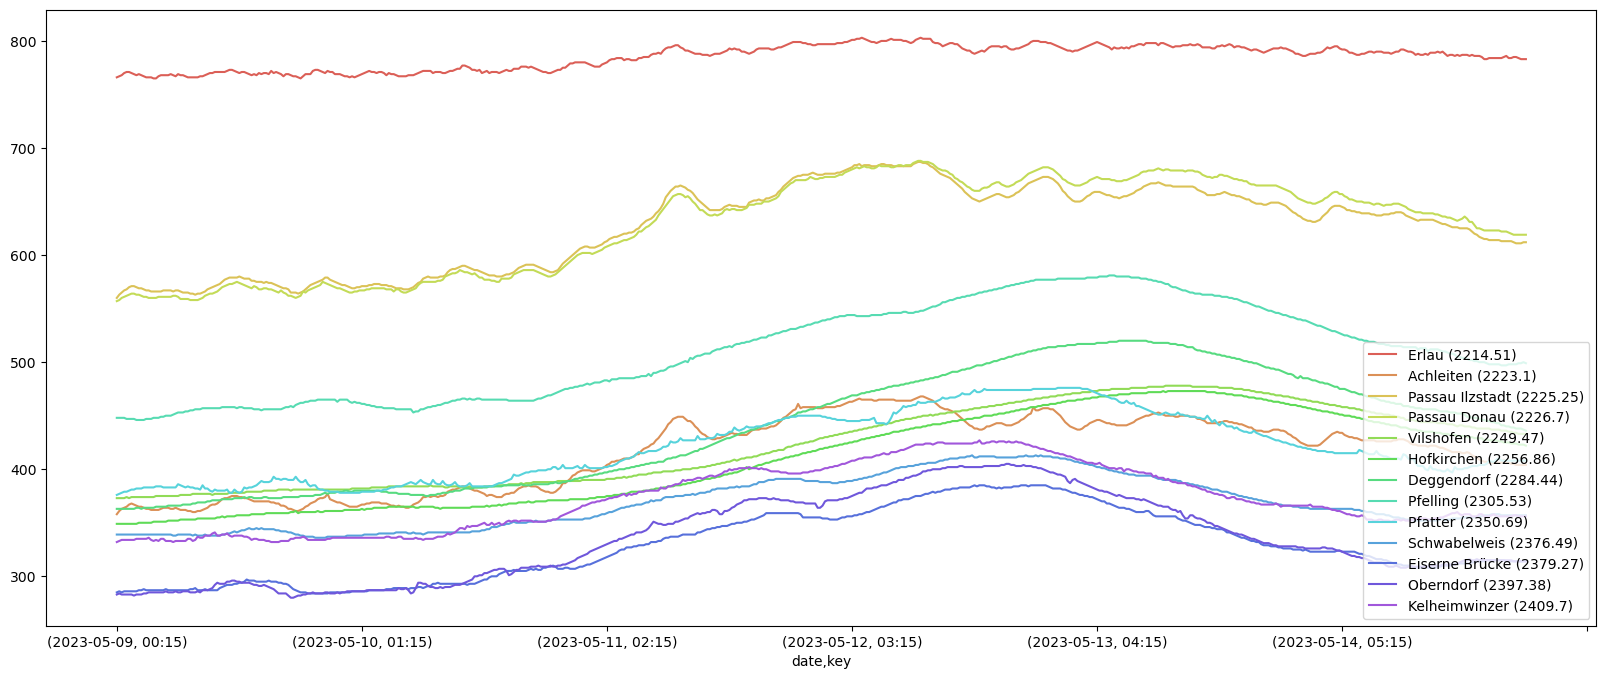

In [100]:

num_colors = data["km"].drop_duplicates().shape[0]

# Generate a list of distinct colors using a seaborn palette
color_palette = sns.color_palette("hls", num_colors)

fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
i = 0
for station, d1 in data[(data.uuid != "0fd56e0a-e32e-4b56-9cda-e0ce93d715c4" ) & (data.date > "2023-05-08") & (data.date < "2023-05-15")].groupby("km"):
    # display(d1.tail(2))
    # if i > 5:
    #     continue

    d1['value_diff'] = d1['value'].diff()

    # # Plot the changes in water level
    # plt.plot(data['date'], data['waterlevel_change'])
    # plt.xlabel('Date')
    # plt.ylabel('Water Level Change')
    # plt.title('Changes in Water Level')
    # plt.show()

    g = d1.groupby(["date", "key"])["value"].mean().plot.line(color=color_palette[i], label=d1.name.values[0] + " (" + str(station) + ")")
    i += 1

axes.legend(loc="lower right")



,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
92245,8,Achleiten,c389c9e2-a5d8-4104-a4cf-510ade44f143,8,10094006,2223.10,Via Donau,48.58,13.50,2023-06-13 09:40:29,2023-05-09,0.00,W,00:15,358.00
92246,8,Achleiten,c389c9e2-a5d8-4104-a4cf-510ade44f143,8,10094006,2223.10,Via Donau,48.58,13.50,2023-06-13 09:40:29,2023-05-09,1.00,W,00:30,361.00


,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
63123,8,Passau Ilzstadt,33ceb441-23bc-4ca6-9fcd-ac35d41ef117,8,10092000,2225.25,Standort Regensburg,48.58,13.48,2023-06-13 09:40:29,2023-05-09,0.00,W,00:15,560.00
63124,8,Passau Ilzstadt,33ceb441-23bc-4ca6-9fcd-ac35d41ef117,8,10092000,2225.25,Standort Regensburg,48.58,13.48,2023-06-13 09:40:29,2023-05-09,1.00,W,00:30,563.00


,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
88088,8,Passau Donau,9f12c405-35ac-4d90-9b7b-023be355867e,8,10091008,2226.70,Standort Regensburg,48.58,13.46,2023-06-13 09:40:29,2023-05-09,0.00,W,00:15,557.00
88089,8,Passau Donau,9f12c405-35ac-4d90-9b7b-023be355867e,8,10091008,2226.70,Standort Regensburg,48.58,13.46,2023-06-13 09:40:29,2023-05-09,1.00,W,00:30,558.00


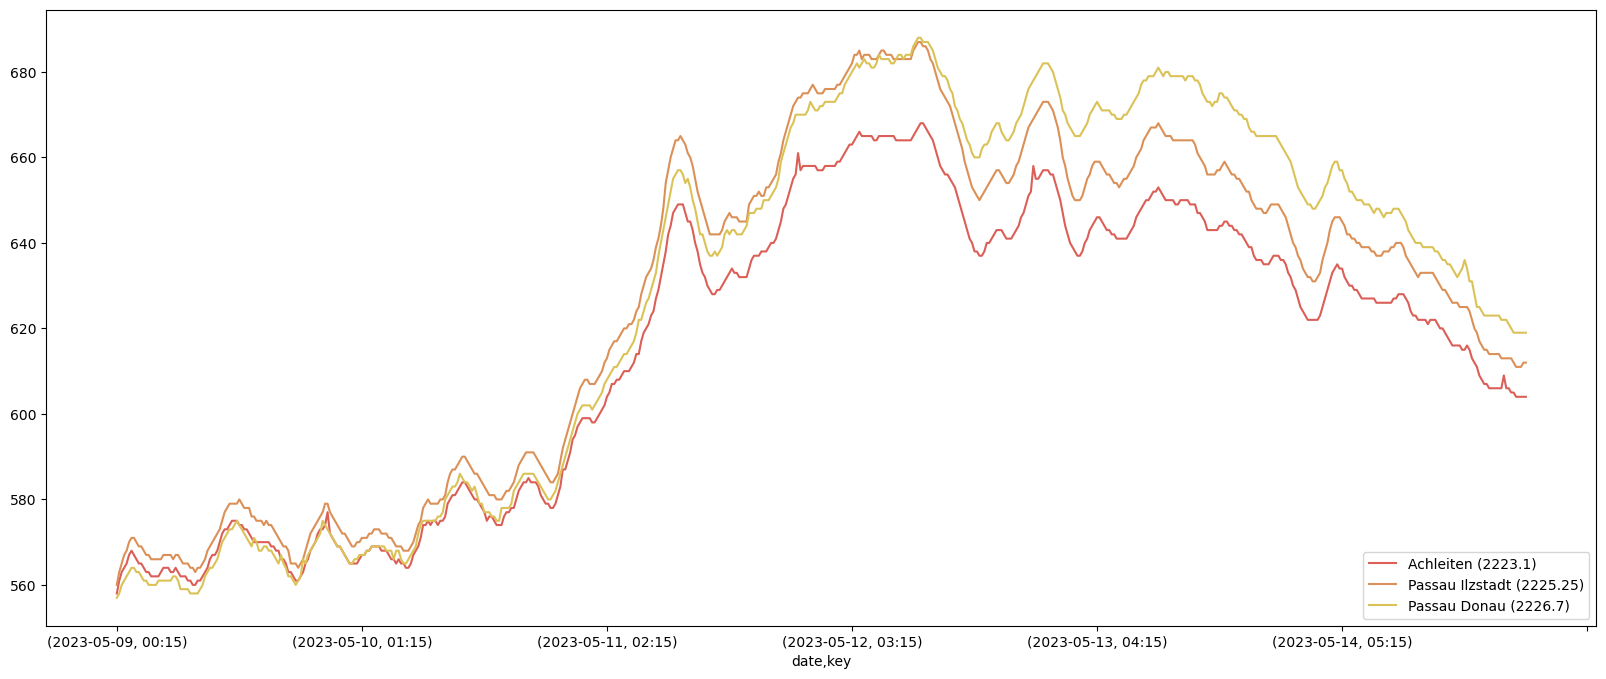

In [117]:

num_colors = data["km"].drop_duplicates().shape[0]

# Generate a list of distinct colors using a seaborn palette
color_palette = sns.color_palette("hls", num_colors)

fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
i = 0
for station, d1 in data[((data.name == "Passau Donau") | (data.name == "Achleiten") | (data.name == "Passau Ilzstadt")) & (data.uuid != "0fd56e0a-e32e-4b56-9cda-e0ce93d715c4" ) & (data.date > "2023-05-08") & (data.date < "2023-05-15")].groupby("km"):
    display(d1.head(2))
    # if i > 5:
    #     continue

    d1['value_diff'] = d1['value'].diff()

    d1.loc[d1.name == "Achleiten", "value"] += 200

    # # Plot the changes in water level
    # plt.plot(data['date'], data['waterlevel_change'])
    # plt.xlabel('Date')
    # plt.ylabel('Water Level Change')
    # plt.title('Changes in Water Level')
    # plt.show()

    g = d1.groupby(["date", "key"])["value"].mean().plot.line(color=color_palette[i], label=d1.name.values[0] + " (" + str(station) + ")")
    i += 1

axes.legend(loc="lower right")



## Let's check the river "Inn" since it flows into the Donau at Passau

In [121]:
data = (pd.DataFrame(run("""SELECT 
        *
    FROM rivers r
    LEFT JOIN stations s ON r.id = s.river_id
    LEFT JOIN timeseries ts ON s.uuid = ts.uuid
    WHERE r.name = "Ilz"
    """)))

#data["km"] = data["km"].astype(float)
display(data.head())
display(data.tail())

""


""


In [ ]:

num_colors = data["km"].drop_duplicates().shape[0]

# Generate a list of distinct colors using a seaborn palette
color_palette = sns.color_palette("hls", num_colors)

fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
i = 0
for station, d1 in data[(data.uuid != "0fd56e0a-e32e-4b56-9cda-e0ce93d715c4" ) & (data.date > "2023-05-08") & (data.date < "2023-05-15")].groupby("km"):
    # display(d1.tail(2))
    # if i > 5:
    #     continue

    d1['value_diff'] = d1['value'].diff()

    # # Plot the changes in water level
    # plt.plot(data['date'], data['waterlevel_change'])
    # plt.xlabel('Date')
    # plt.ylabel('Water Level Change')
    # plt.title('Changes in Water Level')
    # plt.show()

    g = d1.groupby(["date", "key"])["value"].mean().plot.line(color=color_palette[i], label=d1.name.values[0] + " (" + str(station) + ")")
    i += 1

axes.legend(loc="lower right")

In [ ]:
data.dtypes

In [ ]:
data['value'] = data['value'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# non_decimal_values = data[data['value'].notna() & data['value'].astype(str).str.contains('[^0-9.]')]
# print(non_decimal_values['value'].head())

In [ ]:
data = data.astype({
    'date': 'datetime64[D]'})

In [ ]:
display(data.head())
print(data.shape)
display(data.describe())
print(data.dtypes)

In [ ]:
max_std = 0
max_uuid = ""
for uuid, d in data.groupby("uuid"):

    if uuid in [ "8727ebfd-e2e1-43da-ab3d-fee48cff9acc", "438b565e-f293-43c8-8771-377e555ed5ec", "f4f9f7fb-eeff-46dc-9727-04d8aa56240a", "edfdf747-be92-462f-87ed-53d228a33172" ]:
        continue
    elif d["value"].min() <= 0:
        print(uuid, "negative min value", d["value"].min())
        continue

    if ( d["value"].max() - d["value"].min() ) > max_std:
        max_uuid = uuid
        max_std = d["value"].max() - d["value"].min()

print(max_uuid, " (", max_std, ")")

data[data.uuid == max_uuid].describe()

# Twice the amount for a entry
8798527	f4f9f7fb-eeff-46dc-9727-04d8aa56240a	2023-05-22	299	W	05:00	511.00
8798528	f4f9f7fb-eeff-46dc-9727-04d8aa56240a	2023-05-22	300	W	05:01	1023.00
8798529	f4f9f7fb-eeff-46dc-9727-04d8aa56240a	2023-05-22	301	W	05:02	512.00

# Outliers
3539775	edfdf747-be92-462f-87ed-53d228a33172	2023-05-31	650	W	10:51	570.00
3539776	edfdf747-be92-462f-87ed-53d228a33172	2023-05-31	651	W	10:52	6.00
3539777	edfdf747-be92-462f-87ed-53d228a33172	2023-05-31	652	W	10:53	566.00

In [ ]:
data[data.uuid == max_uuid].sort_values("value", ascending=True).head()

In [ ]:
data[(data.uuid == "5d0f9471-f1cb-4b53-9996-067d68d2ce2a")].tail(100)

In [ ]:
import matplotlib.pyplot as plt  #for data visualization operations

fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
#g = data.groupby([data.Order_Date.dt.year, data.Order_Date.dt.month])["TotalSales"].mean().plot.line(color="red")
g = data[data.uuid == "c8b9a2b6-b783-417f-8479-3a0d732fb901"].groupby(["date"])["value"].mean().plot.line(color="red")


In [ ]:
data[(data.uuid == "c8b9a2b6-b783-417f-8479-3a0d732fb901") & (data.date == "2023-06-01")].head()

In [ ]:
data[(data.uuid == "c8b9a2b6-b783-417f-8479-3a0d732fb901") & (data.value < 0)]

In [76]:
data = (pd.DataFrame(run("""SELECT 
        *
    FROM rivers r
    LEFT JOIN stations s ON r.id = s.river_id
    LEFT JOIN timeseries ts ON s.uuid = ts.uuid
    WHERE s.uuid = "c0ec139b-13b4-4f86-bee3-06665ad81a40"
    """)))

data["km"] = data["km"].astype(float)
display(data.head())
display(data.tail())


,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
0,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-05-02,0,W,00:01,552
1,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-05-02,1,W,00:02,550
2,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-05-02,2,W,00:03,549
3,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-05-02,3,W,00:04,547
4,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-05-02,4,W,00:05,546


,id,name,uuid,river_id,number,km,agency,latitude,longitude,last_update,date,idx,type,key,value
62403,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-06-13,496,W,08:17,572
62404,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-06-13,497,W,08:18,571
62405,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-06-13,498,W,08:19,571
62406,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-06-13,499,W,08:20,571
62407,54,Helgoland Binnenhafen,c0ec139b-13b4-4f86-bee3-06665ad81a40,54,9510070,0.00,Standort Tönning,54.18,7.89,2023-06-13 09:40:29,2023-06-13,500,W,08:21,570


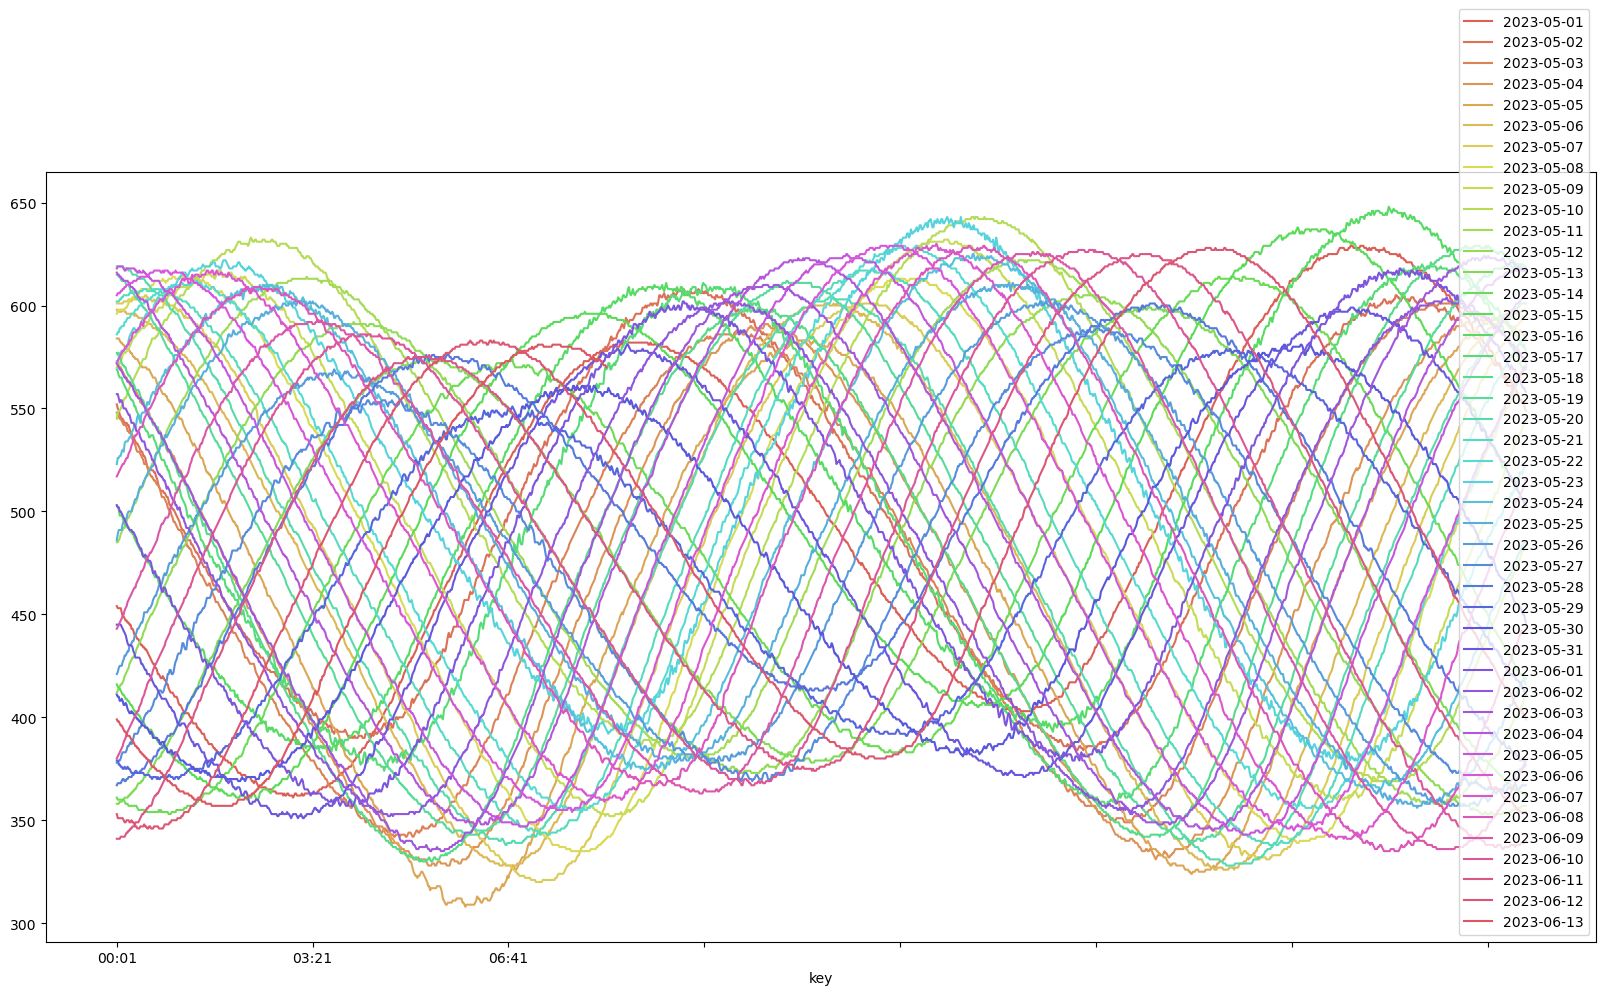

In [79]:
num_colors = len(data.groupby("date"))

# Generate a list of distinct colors using a seaborn palette
color_palette = sns.color_palette("hls", num_colors)


fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 10))
#g = data.groupby([data.Order_Date.dt.year, data.Order_Date.dt.month])["TotalSales"].mean().plot.line(color="red")
i = 0
# 3954300d-f112-4fe6-8d0a-b06496372e36
# 8c8afb56-88ea-483a-a7d4-033c22f53497
# 6dc44585-5b88-45d7-9c64-7c845408b698
# ca3f535b-4a32-4dd7-a56b-2ac20dea4472
# c0ec139b-13b4-4f86-bee3-06665ad81a40
# ca0e4a68-bd50-494c-bd45-abb33c5e1b0a
for date, d in data[data.uuid == "c0ec139b-13b4-4f86-bee3-06665ad81a40"].groupby("date"):
    g = d.groupby(["key"])["value"].mean().plot.line(color=color_palette[i],label=date)
    i += 1
   
axes.legend(loc="lower right")


In [ ]:

# 2203fce7-9d1e-4586-84ab-0797468863a1
# ca0e4a68-bd50-494c-bd45-abb33c5e1b0a
fig, axes = plt.subplots(1, 1, tight_layout=False, figsize = (20, 8))
#g = data.groupby([data.Order_Date.dt.year, data.Order_Date.dt.month])["TotalSales"].mean().plot.line(color="red")
g = data[data.uuid == "ca0e4a68-bd50-494c-bd45-abb33c5e1b0a"].groupby(["date", "key"])["value"].mean().plot.line(color="red")


# Sort order for rivers

In [ ]:
# df = (pd.DataFrame(run("""SELECT 
#         *
#     FROM timeseries ts
    
#     """)))
# display(df.head())

# Plot Folium Map

In [ ]:
# map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# for group_name, group_data in df.groupby([df['water'].apply(lambda x: x['longname'])]):
#     # Create a feature group for the group
#     group = folium.FeatureGroup(name=group_name)
#     if group_name != "XEMS":
#         #display(group_data.sort_values("km"))#[["agency", "km", "longname"]])
#         #break
#         locations = []
#         # Add markers for each point in the group

#         # Print the sorted locations
#         for index, row in group_data.sort_values("km").iterrows():
#             #print(loc["agency"], loc["km"], loc["longname"])
#             locations.append((row['latitude'], row['longitude']))
#             folium.Marker(row[['latitude', 'longitude']], popup=group_name + " / " + row['longname'].lower() + " / " + row['agency'].lower() + " / " + str(row['km'])).add_to(group)
        
#         #print(locations)
#         # Create lines between points in the group
#         #locations = group_data[['latitude', 'longitude', group_name[0]]].values.tolist()
#         folium.PolyLine(locations, color='blue', weight=2.5).add_to(group)

#         # Add the group to the map
#         group.add_to(map)

# # Add layer control to the map
# folium.LayerControl().add_to(map)

# # Display the map
# map


# DB

# DB Disconnect

In [ ]:
cur.close()
con.close()